- Predict score associated with each player in FPL
- Pack most valuable 11 players with given budget
- For formation in acceptable_formations
    - Choose cheapest GK. 
    - Use knapsack to choose 14 players, score of team is first 11 players. 
    - Key Idea :
        - View team building as 3 different knapsack problems for attackers, defenders and midfielders. 
        - Randomize order of choosing attacker or defender first. 

In [1]:
import numpy as np
import collections
import pandas as pd
import torch
import numpy as np
import random
from random import shuffle
np.random.seed(17)
random.seed(17)
torch.manual_seed(17)
import wget
import os
import aiohttp
import asyncio
from fpl import FPL
from torch.utils.data import TensorDataset, DataLoader
from player import Player
from team import Team
from data_processor import get_fpl, get_current_squad
from agent import Agent
import itertools
from collections import defaultdict
'done'

'done'

In [16]:

def knapsack(weights, values, names, max_weight, num_players, teams=[], max_players_from_one_team=3, global_num_teams_in_path=defaultdict(int)):
    '''
        Args
            weights - array of length n 
            values - array of length n
            names - array of length n 
            max_weight - max weight that can be put in knapsack 
            num_players - max num of players
            teams - array of length n teams to which players belong to 
            max_players_from_one_team - max number of players from one team
        Returns
            subset of values whose sum is maximal and its weight being under max_weight
        No path should have more than 3 players from the same team
    '''
    dp = np.zeros((len(weights) + 1, max_weight + 1))
    paths = []
    teams_in_path = []
    for i in range(dp.shape[0]):
        path = []
        team_in_path = []
        for j in range(dp.shape[1]):
            path.append([])
            team_in_path.append([])
        paths.append(path)
        teams_in_path.append(team_in_path)

    for i in range(1, dp.shape[0]):
        for j in range(1, dp.shape[1]):
            is_valid = True 
            num_teams_in_path = defaultdict(int)
            for team in teams_in_path[i-1][j-weights[i-1]]:
                num_teams_in_path[team] += 1
            is_valid = num_teams_in_path[teams[i-1]] < max_players_from_one_team and global_num_teams_in_path[teams[i-1]] < max_players_from_one_team


            if is_valid and j >= weights[i-1] and (values[i-1] + dp[i-1][j-weights[i-1]] >= dp[i-1][j]) and len(paths[i-1][j-weights[i-1]]) < num_players:
                dp[i][j] = values[i-1] + dp[i-1][j-weights[i-1]]
                paths[i][j].extend(paths[i-1][j-weights[i-1]] + [names[i-1]])
                teams_in_path[i][j].extend(teams_in_path[i-1][j-weights[i-1]] + [teams[i-1]])
            else:
                dp[i][j] = dp[i-1][j]
                paths[i][j] = list(paths[i-1][j])
                teams_in_path[i][j] = list(teams_in_path[i-1][j])
    

    best_path = dp[-1].argmax()    
    
    indices = [ names.index(name) for name in paths[-1][best_path] ]
    best_weights = [weights[index] for index in indices]
    best_values = [values[index] for index in indices] 
    for team in teams_in_path[-1][best_path]:
        global_num_teams_in_path[team] += 1
    return paths[-1][best_path], best_weights, best_values, global_num_teams_in_path
#knapsack(weights=[1, 2, 3], values=[3, 4, 1], names=['a', 'b', 'c'],max_weight=5, num_players=3)
knapsack(weights=[4, 3, 1], values=[2, 2, 1], names=['a', 'b', 'c'],max_weight=5, num_players=3, teams=['t1','t1','t1'],max_players_from_one_team=2)



(['b', 'c'], [3, 1], [2, 1], defaultdict(int, {'t1': 2}))

In [17]:
opponent_feature_names = ["npxG","npxGA"]
player_feature_names = ["total_points", "ict_index", "clean_sheets", "saves", "assists"]

agent = Agent(player_feature_names, opponent_feature_names, model_path="./trained_models/player_oppponent_linear_score_model.pt")
await agent.get_data()
await agent.update_model()
current_squad, non_squad = await agent.get_new_squad(player_feature_names, opponent_feature_names)

/home/ajayrfhp/miniconda3/envs/control/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378083779/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/ajayrfhp/miniconda3/envs/control/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/home/ajayrfhp/Documents/Control/Control_FPL/data_processor.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

(0.7760393934999701, 0.44892835711744167)


Kieran Tierney tensor(4.1874) Defender
Trent Alexander-Arnold tensor(4.8473) Defender
Aaron Cresswell tensor(4.2157) Defender
Bernardo Fernandes Da Silva Junior 0 Defender
Charlie Goode tensor(1.8519) Defender
Richarlison de Andrade tensor(4.6813) Forward
Jamie Vardy tensor(4.6644) Forward
Daniel N'Lundulu 0 Forward
Alisson Ramses Becker tensor(5.0718) Goalkeeper
Rúnar Alex Rúnarsson tensor(1.8562) Goalkeeper
Tomas Soucek tensor(4.7620) Midfielder
Pablo Fornals tensor(4.6957) Midfielder
Mohamed Salah tensor(5.9908) Midfielder
Sadio Mané tensor(5.6857) Midfielder
Lucas Torreira tensor(1.8562) Midfielder


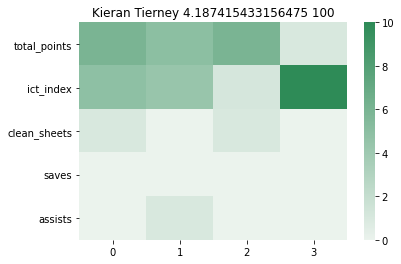

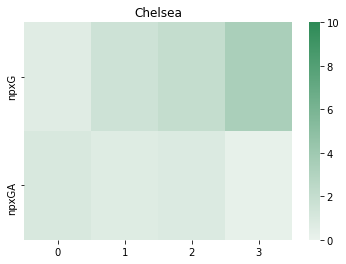

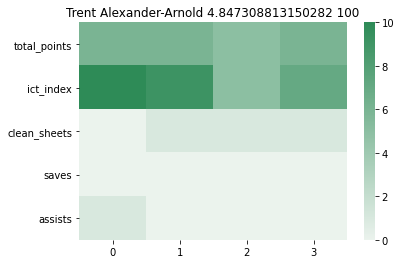

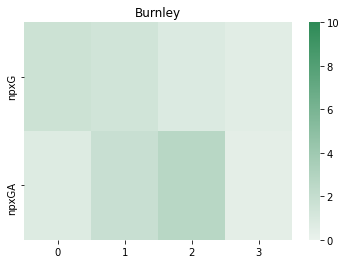

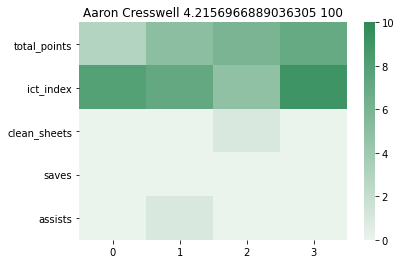

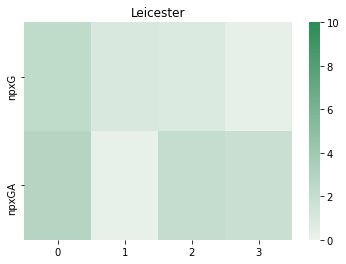

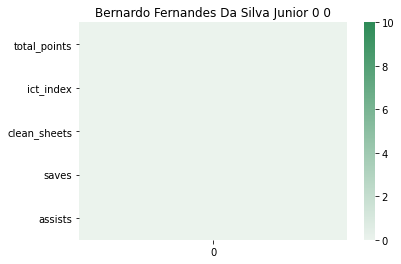

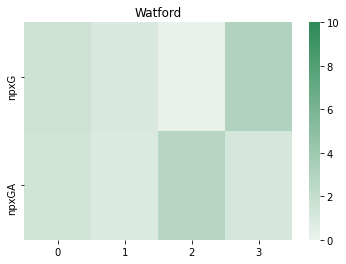

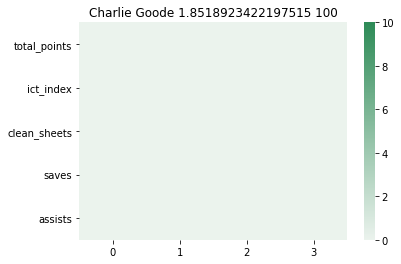

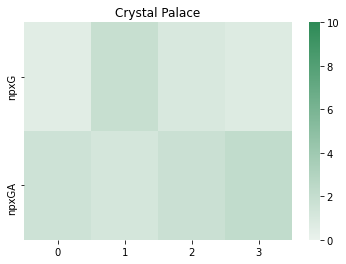

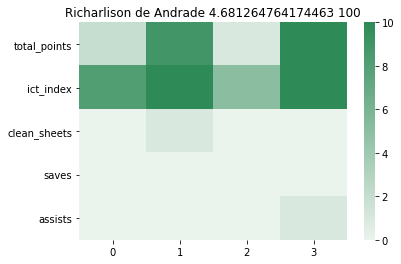

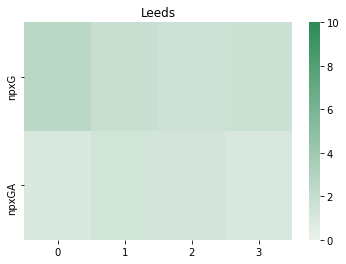

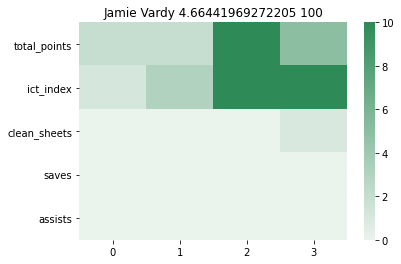

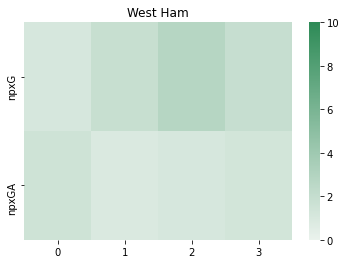

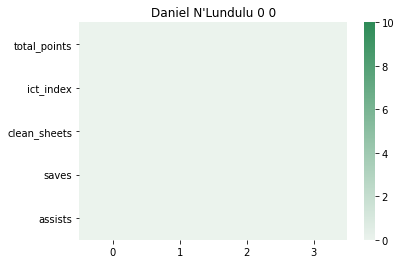

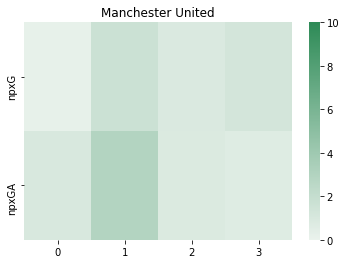

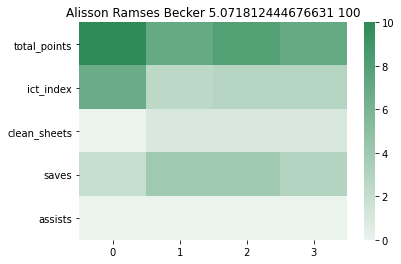

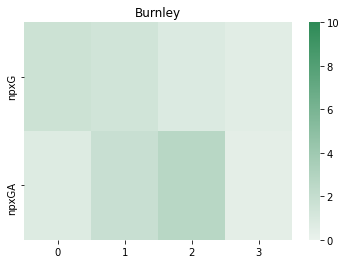

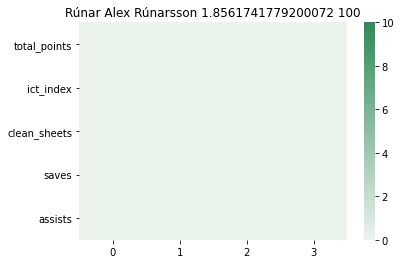

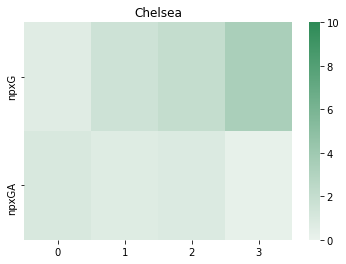

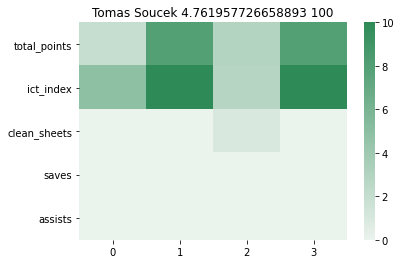

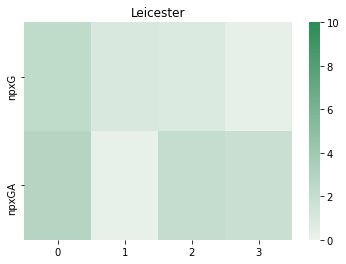

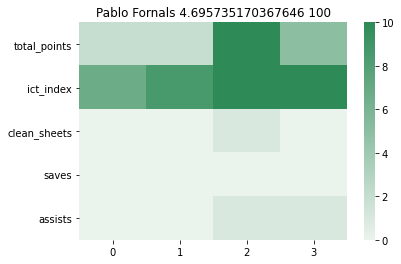

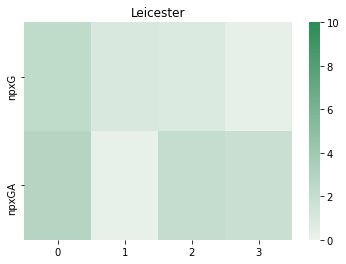

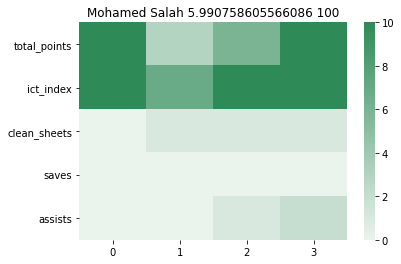

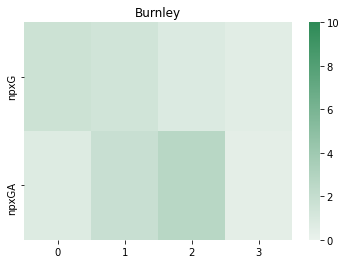

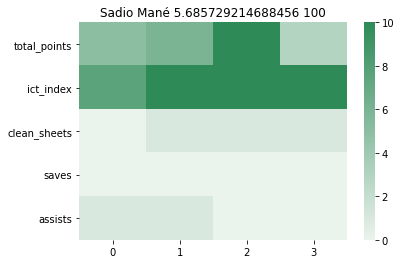

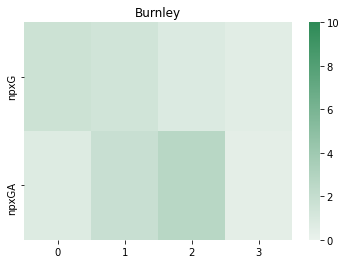

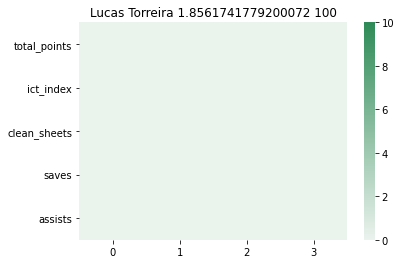

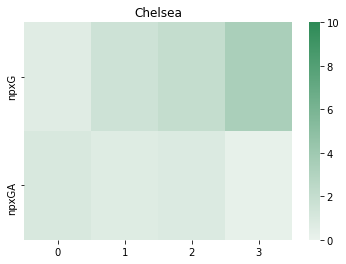

In [24]:
squad = non_squad + current_squad
injuries = pd.read_csv('./injuries.csv')['Name'].tolist()
squad = [player for player in squad if player.name not in injuries]

def knapsack_by_position(squad, position, num_players, max_weight, global_num_teams_in_path):
    players_in_position = [player for player in squad  if player.position == position ]
    weights, values, teams = [], [], []
    for player in players_in_position:
        weights.append(player.latest_price)
        total_points = player.player_features[-15:,0].mean() / 10# lazy approximation
        form_points = player.predicted_performance 
        weighted_points = total_points + form_points
        values.append(weighted_points)
        teams.append(player.team)
    return knapsack(weights=weights, values=values, names=players_in_position, max_weight=max_weight, num_players=num_players, teams=teams, global_num_teams_in_path=global_num_teams_in_path)

def get_team_by_knapsack(squad, max_weight=1000):
    positions = [('Goalkeeper', 2, 1), ('Defender', 5, 3), ('Midfielder', 5, 4), ('Forward', 3, 2)] # Modeller bias - select 3 contributing defenders, 4 midfielders, 2 forwards and 1 gk. Choose filler players for other posiiton
    best_15, best_value = [], -np.inf
    
    for (position_ordering) in itertools.permutations(positions):
        budget = max_weight
        potential_best_15, potential_best_value = [], 0
        
        global_num_teams_in_path = defaultdict(int)
        for position, num_players, num_contribution in position_ordering:
            # choose best 11 by knapsack
            best_player_in_position, best_weights_in_position, best_values_in_position, global_num_teams_in_path = knapsack_by_position(squad, position, num_contribution, budget, global_num_teams_in_path)
            budget -= sum(best_weights_in_position)
            potential_best_15.extend(list(best_player_in_position))
            potential_best_value += sum(best_values_in_position)
            
            # choose cheap filler players
            players_in_position = [player for player in squad if player.position == position and global_num_teams_in_path[player.team] <= 2]
            players_in_position = sorted(players_in_position, key = lambda x : x.latest_price)[:(num_players-num_contribution)]
            budget -= sum([player.latest_price for player in players_in_position])
            potential_best_15.extend(players_in_position)  
        
        
        potential_best_15 = sorted(potential_best_15, key = lambda x : x.position)
        if potential_best_value >= best_value and len(potential_best_15) == 15:
            best_15 = list(potential_best_15)
            best_value = potential_best_value
    for player in best_15:
        print(player.name, player.predicted_performance, player.position)
    for player in best_15:    
        player.visualize()


get_team_by_knapsack(squad, 1000)

- Show top performer by position

In [ ]:
agent.show_top_performers(squad, k=5)